# Hito 3
### Equipo: Data Machine Consulting Group

`ruta_bases`: dirección relativa o absoluta de la carpeta donde se encuentran las bases a utilizar.  

In [1]:
# Parámetros generales del notebook
ruta_bases = 'bases/'

In [2]:
# Importación de librerías
import json
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import funciones as fn
import seaborn as sns
import scipy.stats as stats
import pylab 
import warnings
warnings.filterwarnings('ignore')
from ml_classes import PrepML, MLModel
from matplotlib.pyplot import rcParams
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge,SGDRegressor
from lib.get_nhtsa_json import get_nhtsa_json
from pandas.api.types import CategoricalDtype

In [3]:
# Parámetros generales para plots
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 8
plt.style.use('ggplot')
# Semilla pseudo-aleatoria
rd_seed = 1234

# 0. Obtener la información

Esta es una demostración del proceso realizado por `get_features.py` para poder obtener información relacionada con el `Vin` de los vehículos a través de una API. El proceso consite en los siguientes pasos:
* 1.- Extraer todos los `Vin` de la base completa `true_car_listings.csv`.
* 2.- Requerir a través de la Api 'chunks' de 50 registros por cada petición.
* 3.- Guardar en la memoria el json en formato texto, agregando 50 registros por cada iteración.
* 4.- Una vez completada las iteraciones guardar en formato json todos los registros requeridos.

```python
# Requerimos todos los 'Vin'    
all_vins = pd.read_csv(f'{ruta_bases}true_car_listings.csv')['Vin'].to_list()
# Parámetros de muestra
start = 8
end = 8

json_text = '['
for i in range(start, end+1):
    # Generar requerimiento con 50 registros Vin
    vin_list = all_vins[50 * (i - 1):50 * i]
    json_text += get_nhtsa_json(vin_list, i)

# Cerrar lista de Json
json_text = json_text[:-2] + ']'
# Exportar resultados a archivo json
with open(f'api_test/data_{start}_{end}.json', 'w') as json_file:
    json_file.write(json_text)
```

Paralelamente, en base a una muestra de la base total, se definió el primer filtro de variables requeridas a través la API: que tengan menos del 10% de datos perdidos, las cuales se presentan a continaución:

```python
cols = ['AirBagLocFront', 'BodyClass', 'BusFloorConfigType', 'BusType',
       'CustomMotorcycleType', 'DisplacementCC', 'DisplacementCI',
       'DisplacementL', 'Doors', 'EngineCylinders', 'EngineHP', 'EngineKW',
       'ErrorCode', 'ErrorText', 'FuelTypePrimary', 'Make', 'Manufacturer',
       'ManufacturerId', 'Model', 'ModelYear', 'MotorcycleChassisType',
       'MotorcycleSuspensionType', 'PlantCity', 'PlantCountry', 'TPMS',
       'TrailerBodyType', 'TrailerType', 'VIN', 'VehicleType']
```

Con estas columnas seleccionadas, se procede a importar los archivos json (varios en el proceso original) para luego mapearlos para retraer solo aquellas columnas, creando un DataFrame con ellas y luego exportarlas en un csv.

```python
# Importación de archivo json
filenames = glob.glob('api_test/*.json')
json_list = []

for filename in filenames:
    print(filename)
    with open(filename, 'r') as file:
        # Mapeamos considerando solo las columnas seleccionadas
        data = list(map(fn.get_info, 
                        json.loads(file.read())
                       )
                   )
    json_list += data

# Creación y exortación de DataFrame con features extraídos
data_json = pd.DataFrame(data=json_list,
                         columns=cols)
data_json.to_csv('api_test/data_api.csv')
````

# 1. Creación del Dataset 

## 1.1 Bases Originales

In [4]:
# Importación de las bases para muestras de entrenamiento y prueba
df_train = pd.read_csv(f'{ruta_bases}true_cars_train.csv',
                       delimiter=";")
df_test = pd.read_csv(f'{ruta_bases}true_cars_test.csv',
                      delimiter=";")
# Dimensiones de las bases
print(f'Base Train: {df_train.shape}\nBase Test: {df_test.shape}')

Base Train: (639145, 8)
Base Test: (212977, 8)


In [5]:
# Información general de muestra de entrenamiento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639145 entries, 0 to 639144
Data columns (total 8 columns):
Price      639145 non-null int64
Year       639145 non-null int64
Mileage    639145 non-null int64
City       639145 non-null object
State      639145 non-null object
Vin        639145 non-null object
Make       639145 non-null object
Model      639145 non-null object
dtypes: int64(3), object(5)
memory usage: 39.0+ MB


In [6]:
# Creación de atributo 'sample'
df_train['sample'] = 'train'
df_test['sample'] = 'test'

In [7]:
# Unión de ambas bases
df_data = pd.concat([df_train, df_test])
print(f'Base Data: {df_data.shape}')

Base Data: (852122, 9)


## 1.2 Base API

In [8]:
# Importación de la base extraída por el requerimiento a la api
df_api = pd.read_csv(f'{ruta_bases}api_features.csv').drop(columns='Unnamed: 0')
print(f'Base API: {df_api.shape}')

Base API: (846562, 29)


In [9]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846562 entries, 0 to 846561
Data columns (total 29 columns):
AirBagLocFront              797265 non-null object
BodyClass                   845535 non-null object
BusFloorConfigType          843524 non-null object
BusType                     843524 non-null object
CustomMotorcycleType        846525 non-null object
DisplacementCC              839096 non-null float64
DisplacementCI              839096 non-null float64
DisplacementL               839096 non-null float64
Doors                       739918 non-null float64
EngineCylinders             735744 non-null object
EngineHP                    380764 non-null object
EngineKW                    380764 non-null object
ErrorCode                   846550 non-null object
ErrorText                   846550 non-null object
FuelTypePrimary             789859 non-null object
Make                        846525 non-null object
Manufacturer                846525 non-null object
ManufacturerId    

In [10]:
# Identificar columnas con solo valores "Not Applicable" 
notapp_series = df_api\
                    .isin(['Not Applicable'])\
                    .sum()
cols2drop = list(notapp_series[notapp_series > 1].index)

In [11]:
# Borrar aquellas columnas 
df_api = df_api.drop(columns=cols2drop)
print(f'Base API: {df_api.shape}')

Base API: (846562, 22)


In [12]:
# Renombrar columnas
df_api=df_api.rename(columns={"AirBagLocFront":"d_AirBagLocFront",
                        "BodyClass":"d_BodyClass",
                        "DisplacementCC":"d_DisplacementCC",
                        "DisplacementCI":"d_DisplacementCI",
                        "DisplacementL":"d_DisplacementL",
                        "Doors":"d_Doors",
                        "EngineCylinders":"d_EngineCylinders",
                        "EngineHP":"d_EngineHP",
                        "EngineKW":"d_EngineKW",
                        "ErrorCode":"d_ErrorCode",
                        "ErrorText":"d_ErrorText",
                        "FuelTypePrimary":"d_FuelTypePrimary",
                        "Make":"d_Make",
                        "Manufacturer":"d_Manufacturer",
                        "ManufacturerId":"d_ManufacturerId",
                        "Model":"d_Model",
                        "ModelYear":"d_ModelYear",
                        "PlantCity":"d_PlantCity",
                        "PlantCountry":"d_PlantCountry",
                        "TPMS":"d_TPMS",
                        "VIN":"Vin",
                        "VehicleType":"d_VehicleType"})

## 1.3 Unión de Bases

In [13]:
# Unión de bases
df = pd.merge(left=df_data, 
              right=df_api, 
              how='inner',
              on='Vin')
# Dimensiones de la base
print(f'Dataset: {df.shape}')

Dataset: (846644, 30)


In [14]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846644 entries, 0 to 846643
Data columns (total 30 columns):
Price                846644 non-null int64
Year                 846644 non-null int64
Mileage              846644 non-null int64
City                 846644 non-null object
State                846644 non-null object
Vin                  846644 non-null object
Make                 846644 non-null object
Model                846644 non-null object
sample               846644 non-null object
d_AirBagLocFront     797359 non-null object
d_BodyClass          845629 non-null object
d_DisplacementCC     839190 non-null float64
d_DisplacementCI     839190 non-null float64
d_DisplacementL      839190 non-null float64
d_Doors              740010 non-null float64
d_EngineCylinders    735838 non-null object
d_EngineHP           380796 non-null object
d_EngineKW           380796 non-null object
d_ErrorCode          846644 non-null object
d_ErrorText          846644 non-null object
d_FuelTy

## 1.4 Limpieza del Dataset

### 1.4.1 ErrorText

La columna ErrorText, nos entrega información relevante respecto a los datos obtenidos desde la API y su relación con el número único VIN. A partir de ella, se decide mantener solo aquellos datos que se obtuvieron de manera correcta (845778 de 846644). 

In [15]:
# revisamos la columna ErrorText, que entrega información respecto errores en la extracción de los datos
df['d_ErrorText'].value_counts().sort_values()

1 - Check Digit (9th position) does not calculate properly; 4 - VIN corrected, error in one position only (indicated by ! in Suggested VIN), multiple matches found                                                                                            1
6 - Incomplete VIN; 7 - Manufacturer is not registered with NHTSA for sale or importation in the U.S. for use on U.S roads; Please contact the manufacturer directly for more information; 11 - Incorrect Model Year, decoded data may not be accurate         1
1 - Check Digit (9th position) does not calculate properly; 11 - Incorrect Model Year, decoded data may not be accurate                                                                                                                                        1
1 - Check Digit (9th position) does not calculate properly; 2 - VIN corrected, error in one position; 14 - Unable to provide information for all the characters in the VIN.                                                          

In [16]:
# Se mantienen solo los datos extraídos correctamente
df = df[(df['d_ErrorText'] == '0 - VIN decoded clean. Check Digit (9th position) is correct') |
       (df['d_ErrorText'] == '0 - VIN decoded clean. Check Digit (9th position) is correct; 14 - Unable to provide information for all the characters in the VIN.')]

In [17]:
#se eliminan las columnas de error que ya utilizamos
df = df.drop(columns=["d_ErrorCode","d_ErrorText"])

In [18]:
# Limpieza de atributo
df["d_EngineCylinders"] = df["d_EngineCylinders"].map(lambda x: float(str(x)\
                                                                   .replace('12, 8', '12')\
                                                                   .replace('8, 12', '8'))
                                                                   )

### 1.4.2 Nulos, datos duplicados y columnas duplicadas

In [19]:
#Datos nulos
#Mediante "isnull()", sum() y shape() identificamos los atributos con datos nulos y su procentaje relativo.
null = round(df.isnull().sum()/df.shape[0],2) 
null[null>0]

d_AirBagLocFront     0.06
d_DisplacementCC     0.01
d_DisplacementCI     0.01
d_DisplacementL      0.01
d_Doors              0.13
d_EngineCylinders    0.13
d_EngineHP           0.55
d_EngineKW           0.55
d_FuelTypePrimary    0.07
d_PlantCity          0.18
d_PlantCountry       0.06
d_TPMS               0.20
dtype: float64

In [20]:
# Identificar columnas con más de un 15% de datos perdidos y luego los eliminamos
null_series = df_api\
                .isnull()\
                .sum()\
                /df_api.shape[0] 
df = df.drop(columns=list(null_series[null_series > .15].index))

In [21]:
#Datos duplicados
#Observamos la cantidad de registros duplicados en el df.
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df.shape

(161, 24)

In [22]:
# Eliminamos los registros duplicados
df=df.drop_duplicates()

In [23]:
# Columnas duplicadas
# Chequemos si la columna Model, (data set de la academia) y la columna d_Model (data de la API) son iguales.
(df.Model==df.d_Model).value_counts("%")

False    0.839245
True     0.160755
dtype: float64

In [24]:
# vemos los primeros 5 registros de model y d_model.
df[['Model', 'd_Model']] .head(5)

,Model,d_Model
0,ILX5-Speed,ILX
1,ILX5-Speed,ILX
2,ILXAutomatic,ILX
3,TSXAutomatic,TSX
4,TSX5-Speed,TSX


In [25]:
# chequemos si la columna Make, (data set de la academia) y la columna d_Make (data de la API) son iguales.
(df.Make==df.d_Make).value_counts("%")

False    0.905707
True     0.094293
dtype: float64

In [26]:
# Valores unicos columna make.
np.unique(df.Make)

array(['AM', 'Acura', 'Alfa', 'Aston', 'Audi', 'BMW', 'Bentley', 'Buick',
       'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari',
       'Fisker', 'Ford', 'Freightliner', 'GMC', 'Genesis', 'Geo', 'Honda',
       'Hyundai', 'INFINITI', 'Isuzu', 'Jaguar', 'Jeep', 'Kia',
       'Lamborghini', 'Land', 'Lexus', 'Lincoln', 'Lotus', 'MINI',
       'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz',
       'Mercury', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth',
       'Pontiac', 'Porsche', 'Ram', 'Rolls-Royce', 'Saab', 'Saturn',
       'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen',
       'Volvo', 'smart'], dtype=object)

In [27]:
# Valores unicos columna d_make.
np.unique(df.d_Make)

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
       'DODGE, CHRYSLER, VOLKSWAGEN, JEEP, FIAT, RAM, LANCIA', 'FERRARI',
       'FIAT', 'FISKER AUTOMOTIVE', 'FORD', 'FREIGHTLINER', 'GENESIS',
       'GMC', 'GMC, PONTIAC, GEO', 'HONDA', 'HUMMER ', 'HYUNDAI',
       'HYUNDAI, KIA', 'INFINITI', 'ISUZU', 'JAGUAR', 'JEEP', 'KIA',
       'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'LINCOLN', 'LOTUS',
       'MASERATI', 'MAYBACH', 'MAZDA', 'MCLAREN', 'MERCEDES-BENZ',
       'MERCEDES-BENZ, MAYBACH', 'MERCURY', 'MINI', 'MITSUBISHI',
       'NISSAN', 'NISSAN, INFINITI', 'OLDSMOBILE', 'PLYMOUTH', 'PONTIAC',
       'PORSCHE', 'RAM', 'ROLLS ROYCE', 'SAAB', 'SATURN', 'SMART',
       'SPRINTER (DODGE OR FREIGHTLINER)', 'SUBARU', 'SUZUKI', 'TESLA',
       'TOYOTA', 'VOLKSWAGEN', 'VOLVO'], dtype=object)

In [28]:
# Chequemos si la columna Year, (data set de la academia) y la columna d_ModelYear (data de la API) son iguales.
(df.Year == df.d_ModelYear).value_counts("%")

True     0.999987
False    0.000013
dtype: float64

In [29]:
# Eliminación columnas duplicadas provenientes de la API.
df = df.drop(columns=['d_Make',"d_Model","d_ModelYear", 'd_ManufacturerId',
                      'd_DisplacementCI', 'd_DisplacementL'])

In [30]:
# Eliminación de variables no informativas
df = df.drop(columns=['Vin'])

### Comentarios:

Para asegurar la calidad de los registros se revisan los valores nulos y duplicados, en donde podemos observar que los porcentajes de valores nulos por atributo son bastante bajos en general, con excepción de d_engineHP, d_EngineKW, d_TPMS y PlantCity con valores de 0.55, 0.55, 0.2 y 0.18, respectivamente. Estas cuatro variables se eliminan del dataset. 

Respecto a los registros duplicados, se detectan 161 registros bajo esta condición, por lo que se procede a su eliminacion.

Se decide eliminar las columnas d_Make, d_Model, d_modelYear, d_ManufacterID, d_DisplacenemetCI y d_DisplacementL provenientes de la API. En el caso de d_Make, los nombres de las marcas no vienen normalizados, en cambio en Make si. La columna d_Model viene con menos información asociada al modelo respecto a la columna Model. En el dataset hay tres variables relacionadas al Displacement en distintas unidades. Se procede a eliminar dos de ellas. También el atributo d_model_year con Year son muy similares, y se decide eligir el atributo entregado por la academia. Finalmente, d manufacter_id es una columna redundante respecto d_manufacter.

In [31]:
# Inspección general después de limpieza
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845617 entries, 0 to 846643
Data columns (total 17 columns):
Price                845617 non-null int64
Year                 845617 non-null int64
Mileage              845617 non-null int64
City                 845617 non-null object
State                845617 non-null object
Make                 845617 non-null object
Model                845617 non-null object
sample               845617 non-null object
d_AirBagLocFront     796625 non-null object
d_BodyClass          844836 non-null object
d_DisplacementCC     838484 non-null float64
d_Doors              739282 non-null float64
d_EngineCylinders    735176 non-null float64
d_FuelTypePrimary    789327 non-null object
d_Manufacturer       845617 non-null object
d_PlantCountry       797389 non-null object
d_VehicleType        845617 non-null object
dtypes: float64(3), int64(3), object(11)
memory usage: 116.1+ MB


# 2. Análisis exploratorio de datos

## 2.1 Distribución vector objetivo

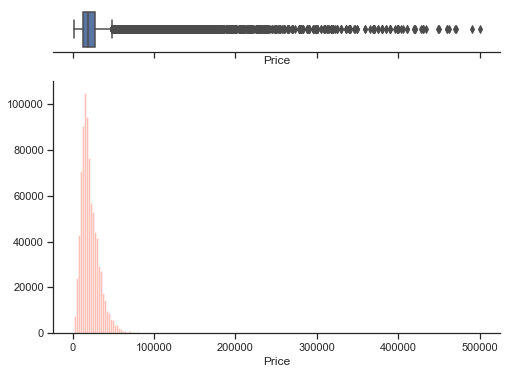

In [32]:
## observamos la distribución del precio mediante un histograma y un gráfico de cajas y bigotes.
fn.distrbution_graph(df.Price)

### Comentarios:

Al observar la distribución del atributo precio (vector objetivo), podemos ver que este es muy variable, teniendo registros con valores muy bajos que parten en los  USD 1.500  como también otros que se disparan del promedio de manera muy marcada alcanzando hasta los USD 499.500. También observamos que la mayoría de los datos se encuetran entre los rangos 0 y 100.000 USD. 

Lo anterior se puede deber a que dentro de la BDD tenemos diferentes tipos de vehiculos cada uno de estos con sus características propias, es por ello que para las demas variables se decide renombrarlas según dichas caracteristicas.

- USE (USE):Atributos relacioados al uso del auto:
Year
Mileage

- SEGMENT (SGT):Atributos asociados al tipo de vehículo:
Vehiculetype
Bodyclass
Make
Model
Manufacture

- FEATURES (FEAT):Atributos asociados las características técnicas del vehículo:
Fuel type
Airbag
Displacement
Doors
EngineCylindren

- LOCALIZATION (LOC):Atributos asociados a la ubicación del vehículo:
state
city

- FABRICATION(FAB):Atributo de ubicación de la fabricación:
Plantcountry

In [33]:
#Se renombran los atributos, según lo indicado anteriormente
df=df.rename(columns={"d_AirBagLocFront":"feat_AirBagLocFront",
                        "d_DisplacementCC":"feat_DisplacementCC",
                        "d_Doors":"feat_Doors",
                        "d_EngineCylinders":"feat_EngineCylinders",
                        "d_EngineHP":"feat_EngineHP",
                        "d_EngineKW":"feat_EngineKW",
                        "d_TPMS":"feat_TPMS",
                        "EngineCylinders":"feat_EngineCylinders",  
                        "d_FuelTypePrimary":"feat_FuelTypePrimary",
                        "d_BodyClass":"sgt_BodyClass",  
                        "d_Manufacturer":"sgt_Manufacturer",
                        "d_VehicleType":"sgt_VehicleType",  
                        "Model":"sgt_Model",
                        "Make":"sgt_Make",
                        "d_PlantCity":"fab_PlantCity",
                        "d_PlantCountry":"fab_PlantCountry",
                        "Year":"use_Year",
                        "Mileage":"use_Mileage",
                        "City":"loc_City",
                        "State":"loc_State"})

## 2.2 Distribución y relaciones de los atributos con el vector objetivo:

### 2.2.1 Atributos features (feat):

#### 2.2.1.1 Matriz de correlación entre atributos "feat" númericos u ordinales con el vector objetivo.

In [34]:
# Generamos lista con columnas feat
col_names_feat = [col for col in df.columns if 'feat' in col]

In [35]:
#generamos df con columnas feat más Price para hacer la matrix de correlación"
df_feat = df[col_names_feat]
df_feat["Price"] = df["Price"]

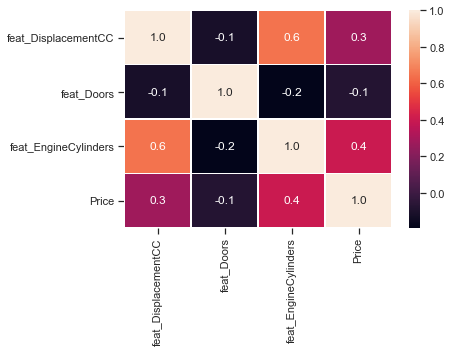

In [36]:
# generamos matriz de correlación entre los atributos númericos u ordinales y nuestro vector objetivo precio.
f,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_feat.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

### 2.2.1.2 Distribución y relación de los atributos categóricos "feat con el vector objetivo.

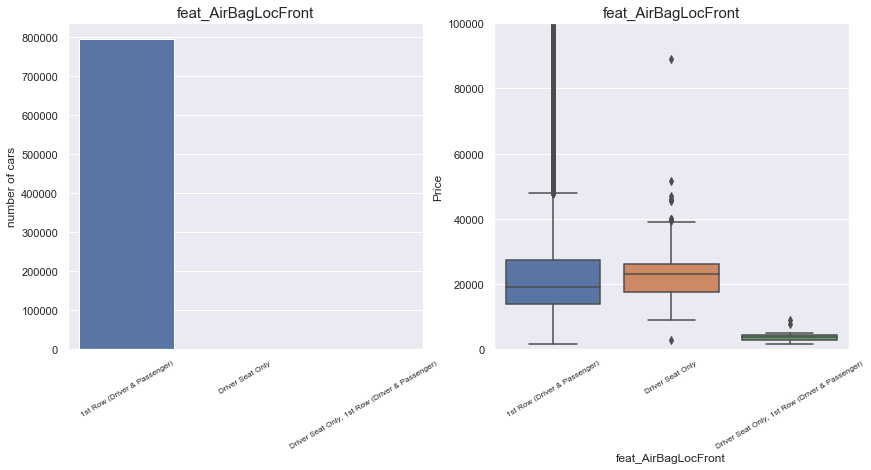

In [37]:
#Variable "feat_airbag"
fn.count_box_plot('feat_AirBagLocFront', df)

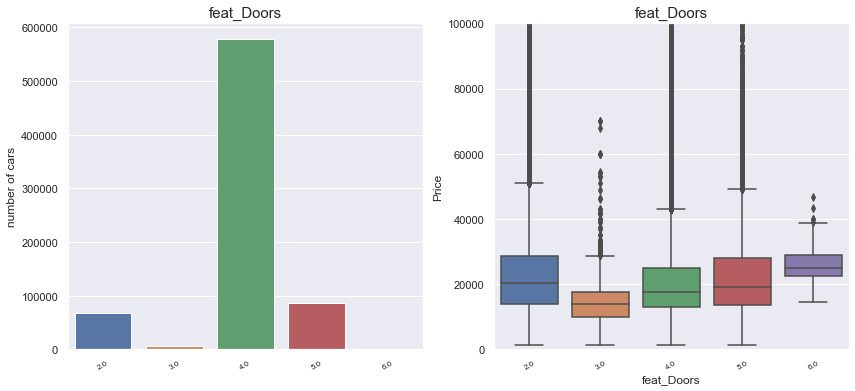

In [38]:
#Variable "feat_Doors"
fn.count_box_plot("feat_Doors", df)

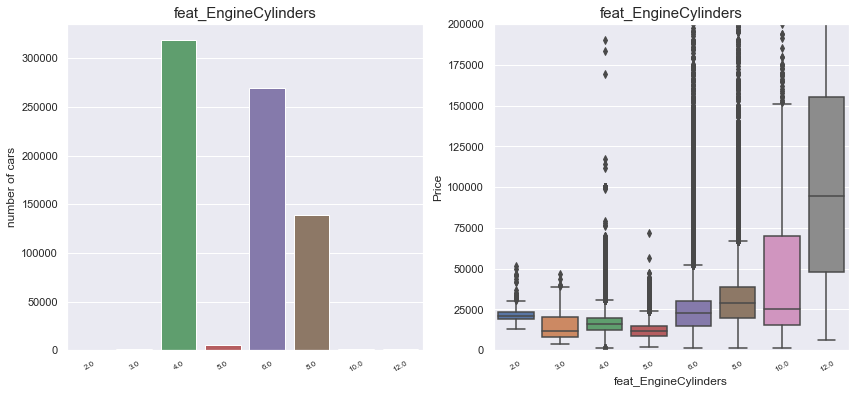

In [39]:
#Variable "feat_EngineCylinders"
fn.count_box_plot("feat_EngineCylinders",df, 200000)

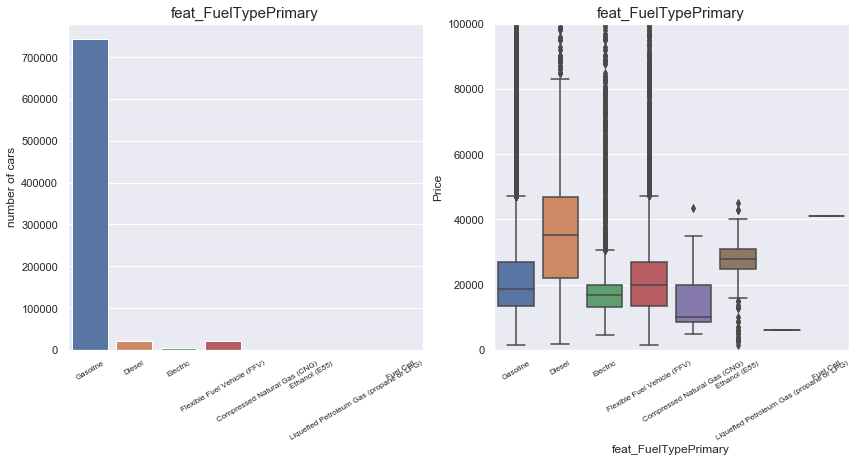

In [40]:
fn.count_box_plot("feat_FuelTypePrimary", df)

### Conclusiones atributos FEAT:

- Los atributos feat_Doors, feat_Airbag y feat_FuelType están considerablemente desbalanceadas hacia una categoría. No se recomiendan utilizar estas variables para el modelamiento de datos.
- Displacement presentan una correlación de 0.3 con el vector objetivo y se sugiere considerar en el modelamiento. 
- Respecto a la variable feat_EngineCylinders presenta una asociación positiva con el precio de 0.4. Se recomienda considerar en el entrenamiento.

### 2.2.2 Distribución atributos Use:

#### 2.2.2.1 Matriz de correlación entre atributos "Use" númericos u ordinales con el vector objetivo.

In [41]:
# Generamos lista con columnas feat
col_names_use = [col for col in df.columns if 'use' in col]

In [42]:
#generamos df con columnas use más Price para hacer la matrix de correlación"
df_use = df[col_names_use]
df_use["Price"] = df["Price"]

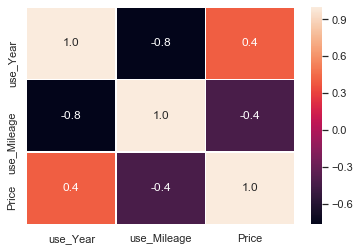

In [43]:
# generamos matriz de correlación entre los atributos númericos u ordinales y nuestro vector objetivo precio.
f,ax = plt.subplots(figsize=(6, 4))
sns.heatmap(df_use.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

#### 2.2.2.2 Distribución y relación de los atributos categóricos "Use" con el vector objetivo.

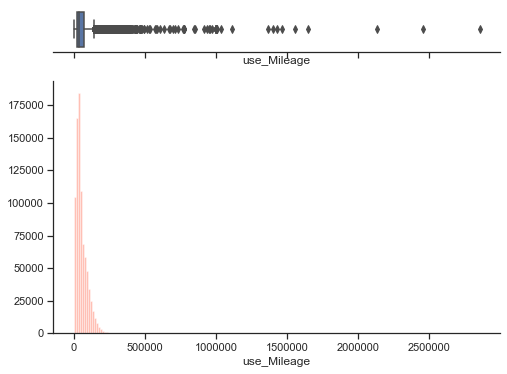

In [44]:
# Variable use_Mileage
fn.distrbution_graph(df.use_Mileage)

Text(0.5, 1.0, 'Mileage and Price relation ')

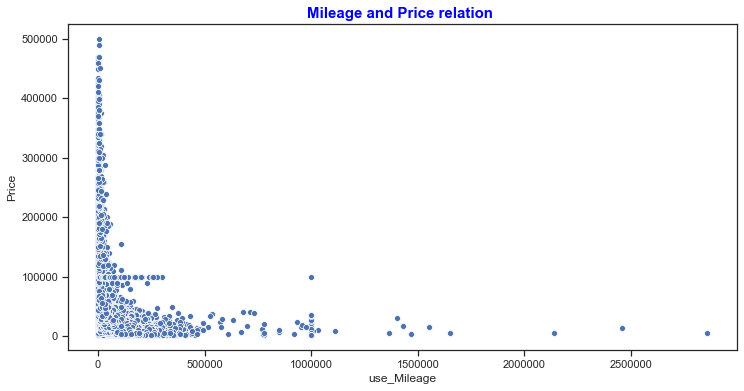

In [45]:
# observamos la distribución de use_Mileage en función del precio, mediante un scatterplot.
plt.figure(figsize=(12,6))
sns.scatterplot(y=df['Price'], x=df['use_Mileage']);
plt.title('Mileage and Price relation ',fontsize=15,color='blue',fontweight='bold')

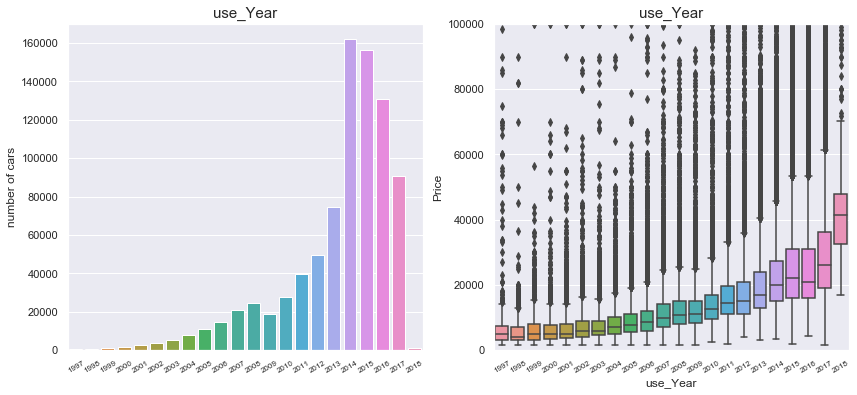

In [46]:
##Variable "Year"
fn.count_box_plot("use_Year", df)

### Conclusiones atributos USE:
- Existe una asociación positiva de 0.4 entre Year y el precio de vehículos.
- Existe una asociación negativa de 0.4 entre Mileage y el precio de los vehículos.
- Entre year y mileage exite una fuerte asociación negativa de 0.8. Dada esta asociación, quizás es recomendable considerar solo una de estos atributos.

### 2.2.3 Distribución atributos localization (loc):

#### 2.2.3.1 Distribución y relación de los atributos categóricos "Loc" con el vector objetivo.

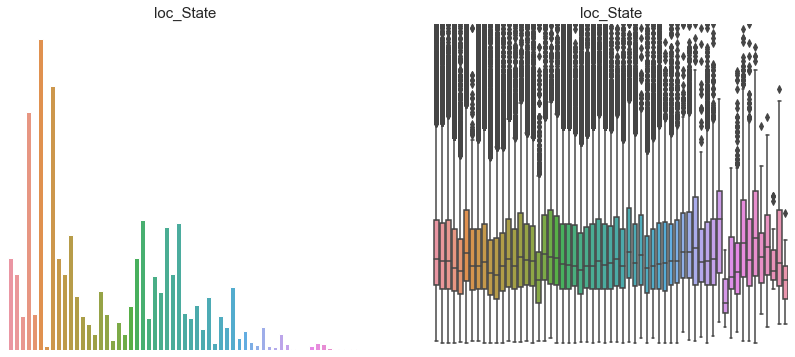

In [47]:
#Variable loc_state
fn.count_box_plot("loc_State",df, 70000,False)

Text(0.5, 1.0, 'City Distribution')

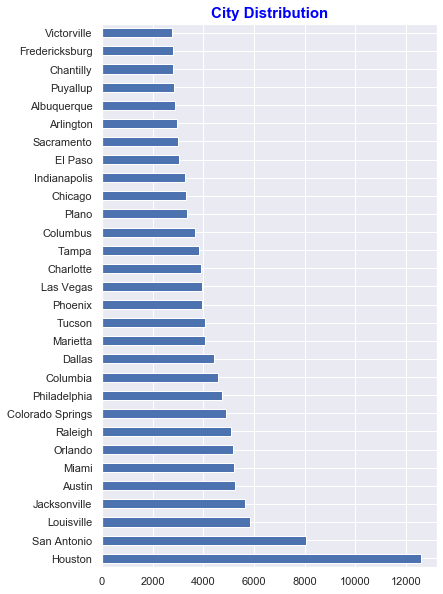

In [48]:
# observamos la distribución de loc_City, mediante un plot
df['loc_City'].value_counts().head(30).plot(kind='barh', figsize=(6,10))
plt.title('City Distribution',fontsize=15,color='blue',fontweight='bold')

### Conclusiones atributos LOC:

- El precio por State presenta una distribución similar. Esto se evidencia al observar los cuartiles y la mediana de los precios en cada uno de los estados. Solo el estado DC, presenta precios inferiores. Se recomienda no considerar esta variable por el momento.

- Dada la complejidad en cuanto al número de ciudades contenidas en la base de datos, por ahora no recomendamos utilizar esta variable en el proceso de entrenamiento. 

### 2.2.4 Distribución atributos de segmentacion (sgt):

#### 2.2.4.1 Distribución y relación de los atributos categóricos "de segmentación "SGT" con el vector objetivo.

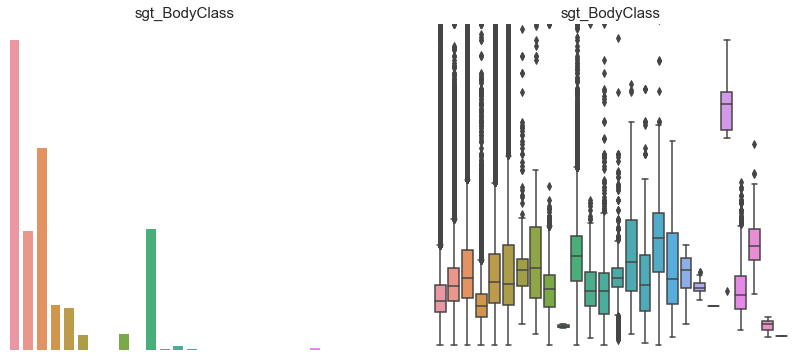

In [49]:
#variable sgt_BodyClass
fn.count_box_plot("sgt_BodyClass",df, 100000,False)                        

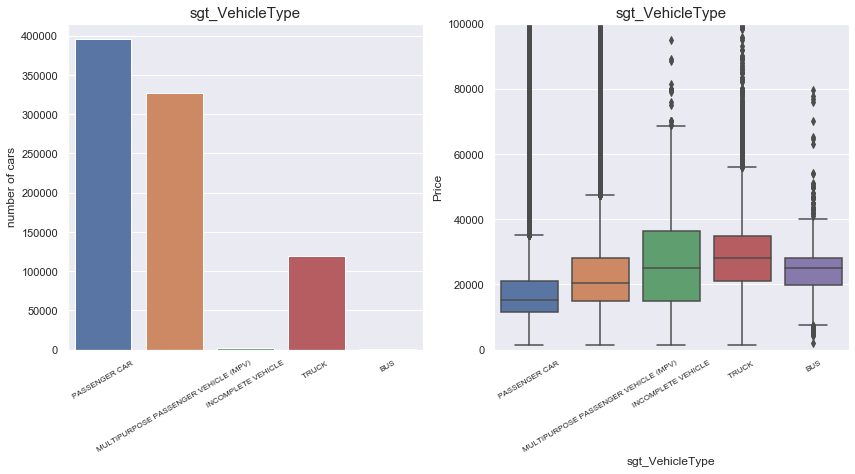

In [50]:
#Variable sgt_VehicleType
fn.count_box_plot("sgt_VehicleType", df)

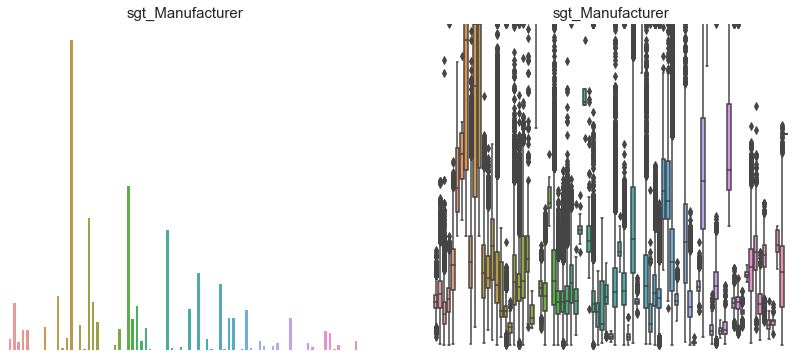

In [51]:
#Variable sgt_Manufacter
fn.count_box_plot("sgt_Manufacturer", df, 100000,False)

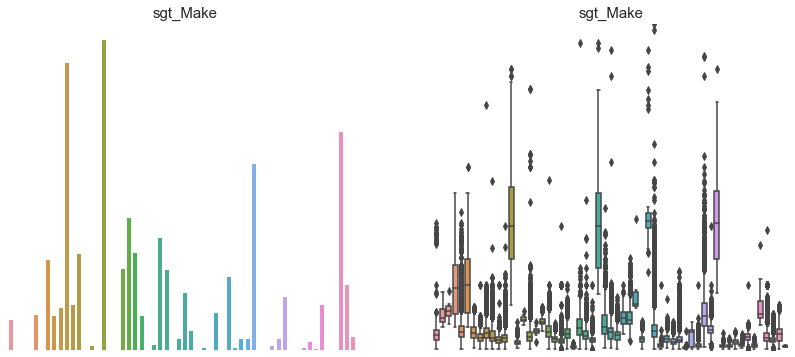

In [52]:
#variable sgt_Make
fn.count_box_plot("sgt_Make", df, 500000,False)

Text(0.5, 1.0, 'Model Distribution')

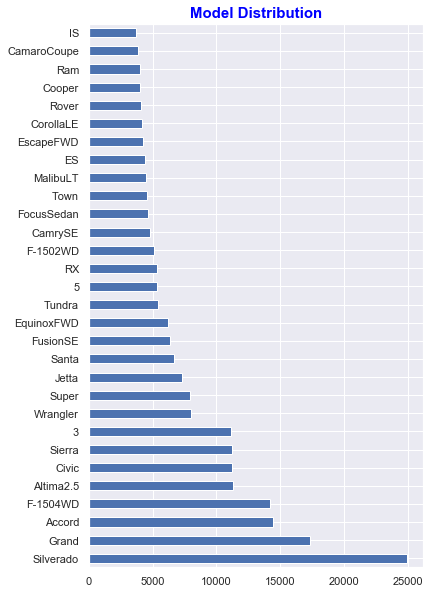

In [53]:
# observamos la distribución de sgt_model, mediante un plot
df['sgt_Model'].value_counts().head(30).plot(kind='barh', figsize=(6,10))
plt.title('Model Distribution',fontsize=15,color='blue',fontweight='bold')

### Conclusiones atributos de segmentación (sgt):

- Los atributos BodyClass, VehicleType, Make y Model y Manufacter muestran variaciones de los precios por categoría. Sin embargo, existen muchas categorías de estas variables con frecuencias muy bajas. Entonces, se recomienda utilizar estas variables previo a reorganización de las categorías marginales.

### 2.2.5 Distribución atributos de fabricación (fab):

#### 2.2.5.1 Distribución y relación de los atributos categóricos de fabricación "fab" con el vector objetivo.

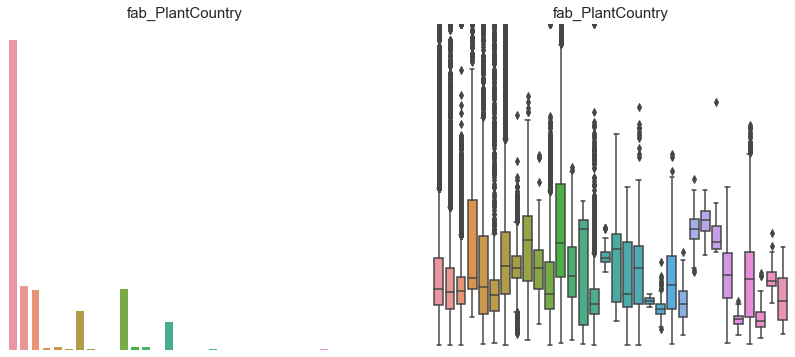

In [54]:
#Variable fab_PlantCountry
fn.count_box_plot("fab_PlantCountry",df, 100000,False)

### Conclusiones atributos de fabricación (fab):

- El atributo PlantCountry muestra variación de los precios entre paises. Sin embargo, también se observan frecuencias de paises marginales. Se recomienda utilizar esta variable para el entrenaminto de los datos previa recategorización.

# 3. Recodificación de variables

## 3.1 Reagrupación de fab_PlantCountry

In [55]:
# reagrupamos el atributo fab_PlantCountry
df['fab_PlantCountry'] = df['fab_PlantCountry'].replace(
                         ['FRANCE','SPAIN', 'PORTUGAL', 'POLAND', 'NETHERLANDS', 'SERBIA', 'FINLAND',"ITALY","UNITED KINGDOM (UK)","AUSTRIA","HUNGARY","ENGLAND","BELGIUM","SWEDEN","SLOVAKIA"],'OTHERS_EUROPE').replace(
                         ['ARGENTINA','VENEZUELA', 'BRAZIL', 'UNITED STATES (USA), CANADA', 'CANADA, UNITED STATES (USA)'],'OTHERS_AMERICA').replace(
                         ['THAILAND','TURKEY', 'CHINA', 'AUSTRALIA', 'INDIA'],'OTHERS_ASIA_OCEANIA').replace(
                         ["OTHERS_AMERICA","OTHERS_ASIA_OCEANIA","SOUTH AFRICA"],"OTHER_COUNTRIES")

In [56]:
# vusalizamos la cantidad de datos para c/u de las variables de fab_PlantCountry
df.fab_PlantCountry.value_counts()

UNITED STATES (USA)    417236
JAPAN                   86370
MEXICO                  83087
CANADA                  81514
GERMANY                 53772
SOUTH KOREA             38222
OTHERS_EUROPE           29065
OTHER_COUNTRIES          8123
Name: fab_PlantCountry, dtype: int64

### Comenatrios fab_PlantCountry.

Las categorías que estan por debajo de los 600 registros, se agrupan en 2 grandes conjuntos: OTHER_EUROPE y OTHER_COUNTRY.
Como resultado de se obtienen 8 categorias.

## 3.2 Reagrupación de sgt_BodyClass

In [57]:
# reagrupamos el atributo sgt_BodyClass
df['sgt_BodyClass'] = df['sgt_BodyClass'].replace(
                      ["Hatchback/Liftback/Notchback, Convertible/Cabriolet"],"Hatchback/Liftback/Notchback").replace(
                      ["Wagon, Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)"],"Wagon").replace(
                      ["Incomplete - Cutaway","Incomplete - Cutaway","Incomplete - Chassis Cab (Number of Cab Unknown)","Incomplete - Chassis Cab (Double Cab)","Incomplete - Stripped Chassis","Incomplete - Commercial Chassis","Incomplete - Motor Home Chassis","Incomplete - Chassis Cab (Single Cab)","Incomplete - Chassis Cab (Double Cab) "],"Incomplete").replace(
                      ["Truck"],"Sport Utility Truck (SUT)").replace(
                      ["Roadster"],"Convertible/Cabriolet").replace(
                      ["Cargo Van"],"Minivan")

In [58]:
# reemplazamos con np.nan, aquellas variables del atributo sgt_BodyClass que tienen una frecuencia marginal 
df = df.replace({'sgt_BodyClass':{"Bus":np.NaN,"Limousine":np.NaN,'Trailer':np.NaN,"Incomplete":np.NaN}})

In [59]:
# vusalizamos la cantidad de datos para c/u de las variables de sgt_BodyClass
df.sgt_BodyClass.value_counts()

Sedan/Saloon                                               294628
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    192158
Pickup                                                     115583
Wagon                                                      113966
Hatchback/Liftback/Notchback                                43629
Coupe                                                       40817
Minivan                                                     17677
Convertible/Cabriolet                                       15612
Van                                                          4857
Crossover Utility Vehicle (CUV)                              2637
Sport Utility Truck (SUT)                                    1656
Name: sgt_BodyClass, dtype: int64

## comentarios sgt_BodyClass

Se agrupan las categorías según automóviles similares. El criterio usado fue juicio experto.
Se decide transformar a NaN las categorías específicas: Bus, Limousine e Incomplete.
Como resultado nos quedamos con 11 tipos de vehiculos.

## 3.3 Reagrupación de sgt_VehicleType

In [60]:
# reemplazamos con np.nan, aquellas variables del atributo sgt_VehicleType que tienen una frecuencia marginal 
df = df.replace({'sgt_VehicleType':{"INCOMPLETE VEHICLE":np.NaN,"BUS":np.NaN,"TRAILER":np.NaN}})

In [61]:
# vusalizamos los Q para c/u de las variables de sgt_VehicleType
df.sgt_VehicleType.value_counts()

PASSENGER CAR                           395708
MULTIPURPOSE PASSENGER VEHICLE (MPV)    326962
TRUCK                                   119952
Name: sgt_VehicleType, dtype: int64

## comentarios sgt_VehicleType

Dado que dentro del atributo `sgt_VehicleType` tenemos variables con una frecuencia muy marginal, se decide no considerarlas, por lo que se transforman a np.nan, quedandonos solo con 3 categorias de vehiculo:

* De pasajeros
* Multiproposito
* Camión

Lo que está muy relacionado con los tipos de vehiculos que comercializa una automotora.

## 3.4 Eliminación de Modelos con menos de 30 observaciones

In [62]:
# Filtrar 30 modelos
modelos = df['sgt_Make'].value_counts()
df = df[df['sgt_Make'].isin(modelos[modelos > 30].index)]

## 3.5 Recodificación de variable año

Cómo la variable año refleja la antiguedad de un vehículo al compararla con un año de referencia (2018 para la base de entrenamiento/prueba), se hace está trasnformación para generar la variable de 'edad' del vehículo.

In [63]:
# Recodificación de variable año 
df['use_Age'] = 2018 - df['use_Year']

# 4. Preproceso

Durante esta etapa se realiza el preprocesamiento necesario de los atributos y vector objetivo para que puedan ser utilizados para entrenar y probar posteriormente en modelos de ML. Primero procedemos a liberar algo de espacio en la memoria RAM borrando las variables usadas durante la construcción del dataset, para luego proceder a la selección de atributos y el muestreo aleatorio de datos a preprocesar.

In [64]:
# Liberar Espacio Memoria
del df_api
del df_data
del df_train
del df_test

### Selección de atributos para el entrenamiento:
Como resultado del Análisis de la distribución de los atributos y de la relación de ellos con el vector objetivo se decide seleccionar 5 atributos para la fase de entrenamiento de modelos:
0. Price (Vector Objetivo)
1. Mileage
2. BodyClass
3. VehicleType
4. Model
5. Age
6. EngineCylinders
7. DisplacementCC

In [65]:
# Selección de variables para modelos
select_vars = ['Price', 'use_Mileage', 'use_Age', 'sample', 
               'sgt_BodyClass', 'sgt_Make', 'sgt_VehicleType',
               'feat_DisplacementCC', 'feat_EngineCylinders']

In [66]:
# Muestra aleatoria
df_sample = df[select_vars]\
                .dropna()\
                .reset_index(drop=True)\

A través de la clase `PrepMl` se realizarán los tres preprocesos seleccionados para esta modelación: __Remove_Outliers__, __OneHot_Encoder__ y __Standard_Scaler__.

In [67]:
# Instanciar clase para realizar preproceso
df_prep = PrepML(df_sample)

In [68]:
# Eliminación de Outliers
df_prep.remove_outliers(['Price', 'use_Mileage', 'use_Age', 
                         'feat_DisplacementCC', 'feat_EngineCylinders'],
                         'sample', iqr_multiplier=1.5, print_diff=True)

Datos para entrenamiento antes de eliminación de outliers: 548342
Datos para entrenamiento después eliminación de outliers: 480430
Proporción de datos para entrenamiento eliminada: 0.124


In [69]:
# Realizamos OneHot Encoder a las columnas categóricas seleccionadas
df_prep.one_hot_encoder(['sgt_BodyClass', 'sgt_Make', 'sgt_VehicleType'],
                        drop_first=True)

In [70]:
# Estandarizamos variables continuas seleccionadas
df_prep.standard_scaler(['use_Mileage', 'use_Age', 'feat_DisplacementCC', 'feat_EngineCylinders'])

In [71]:
# Separar muestras según
X_train, y_train, X_test, y_test, X_val, y_val = df_prep.to_ml_samples('sample', 'Price')

Realizado en 4.0s


# 5. Modelamiento 

A través de la clase `MLModel` a continuación se entrenarán y se realizará una busqueda de grilla para encontrar los mejores hiperparámetros por modelo, y posteriormente evaluar cada mejor modelo con la muestra de prueba. Serán 4 modelos a entrenarse, 2 paramétricos (`Ridge Regression` y `Stochastic Gradient Descent Regression`) y 2 no-paramétricos (`XGBoost` y `LightGBM`, ambas implementaciones de Gradient Boosting).
Primero, se comienza con el entrenamiento de prueba de una Regresión Lineal, para corroborar que no hay errores en el preproceso:

## 5.0 Entrenamiento de Prueba

In [72]:
# Test Entrenamiento
from sklearn.linear_model import LinearRegression
linear_reg = MLModel(LinearRegression())
linear_reg.fit(X_train, y_train)

Realizado en 2.0s


In [73]:
# Métricas entrenamiento de prueba
linear_reg.train_test_metrics(X_train, y_train, X_test, y_test)

,RSME,MAE,R2
Train,4422.0,3367.8,0.768
Test,4437.7,3378.5,0.766


## 5.1 Modelo Único

### 5.1.1 Ridge Regression

```python
# Establecemos parámetros a evaluar en el modelo
ridge_grid = {'alpha': [0, .001, 0.0001],
              'solver': ['sag', 'sparse_cg']}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
ridge_reg = MLModel(model=Ridge(fit_intercept=True))
# Implementación del grid search
ridge_reg.grid_search(X_train,
                      y_train,
                      param_grid=ridge_grid,
                      n_jobs=-2,
                      cv=5)
# Serialización del mejor modelo
ridge_reg.to_pickle(car_category='allcars')
```

In [74]:
# Importamos mejor modelo
ridge_best = MLModel.from_pickle('best_models/allcars_ridge.sav')
# Métricas mejor modelo
ridge_best.train_test_metrics(X_train, y_train, X_test, y_test)

,RSME,MAE,R2
Train,4422.0,3367.7,0.768
Test,4437.7,3378.4,0.766


### 5.1.2 Stochastic Gradient Descent Regression (SGD)

```python
# Establecemos parámetros a evaluar en el modelo
sgd_grid = {'loss': ['squared_epsilon_insensitive', 'squared_loss'],
            'alpha': [0, 0.0001, 0.00001]
          }
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
sgd_reg = MLModel(model=SGDRegressor(penalty = 'l1',
                                     early_stopping = False,
                                     random_state=rd_seed))
# Implementación del grid search
sgd_reg.grid_search(X_train,
                    y_train,
                    param_grid=sgd_grid,
                    n_jobs=-2,
                    cv=5)
# Serialización del mejor modelo
sgd_reg.to_pickle(car_category='all_cars')
```

In [75]:
# Importamos mejor modelo
sgd_best = MLModel.from_pickle('best_models/allcars_sgdregressor.sav')
# Métricas mejor modelo
sgd_best.train_test_metrics(X_train, y_train, X_test, y_test)

,RSME,MAE,R2
Train,4432.8,3370.3,0.766
Test,4449.0,3381.6,0.765


### 5.1.3 LightGBM

```python
# Establecemos parámetros a evaluar en el modelo
lgb_grid = {'max_depth': [11, 12, 13], 
            'num_leaves': [110, 120, 130]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
lgb_reg = MLModel(model=LGBMRegressor(n_jobs=1,
                                      random_state=rd_seed))
# Implementación del grid search
lgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=lgb_grid,
                    n_jobs=-2,
                    cv=5)
# Serialización del mejor modelo
lgb_reg.to_pickle(car_category='allcars')
```

In [76]:
# Importamos mejor modelo
lgb_best = MLModel.from_pickle('best_models/allcars_lgbmregressor.sav')
# Métricas mejor modelo
lgb_best.train_test_metrics(X_train, y_train, X_test, y_test)

,RSME,MAE,R2
Train,2934.4,2143.5,0.898
Test,2980.6,2171.1,0.895


### 5.1.4 XGBoost

```python
# Establecemos parámetros a evaluar en el modelo
xgb_grid = {'max_depth': [7, 8, 9], 
            'n_estimators': [80, 90, 100]}
# Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
xgb_reg = MLModel(model=XGBRegressor(objective ='reg:squarederror',
                                     n_jobs=1,
                                     seed=rd_seed))
# Implementación del grid search
xgb_reg.grid_search(X_train,
                    y_train,
                    param_grid=xgb_grid,
                    n_jobs=2,
                    cv=3)
# Serialización del mejor modelo
xgb_reg.to_pickle(car_category='allcars')
```

In [77]:
# Importamos mejor modelo
xgb_best = MLModel.from_pickle('best_models/allcars_xgbregressor.sav')
# Métricas mejor modelo
xgb_best.train_test_metrics(X_train, y_train, X_test, y_test)

,RSME,MAE,R2
Train,2939.5,2148.8,0.897
Test,3009.8,2196.1,0.893


__Comentarios Generales__:
    
De los resultados obtenidos podemos concluir apriori que:  
1.- Existen relaciones no lineales en la variables que se refleja en la superioridad de los modelos basados en árboles de decisión sobre los modelos lineales. Estos resultados son consistentes con los análisis  intermedios y exploratorios.  
2.- Modelando solo un modelo para calcular el precio de mercado, obtuvimos resultados que alentarían el uso de un único modelo para predecir todos los casos, aunque no se descarta la alterantiva de grupos de modelos para predecir dividendo por alguna categoría queda pendiente a evaluarse en los próximos pasos. 

## 5.2 Modelos Múltiples

Dividimos la muestra según las categorías en `VehicleType`, dado que cada las tres categorías que representa esta variable, divide los autos según la principal función del vehículo: de pasajeros, multipropósito y camiones (para carga). Esta división representaría de mejor forma la relación de los atributos en el precio del vehículo. A continuación, preparamos las muestras para entrenar y evaluar los distintos modelos por categoría de vehículo.

In [78]:
# Creación de diccionarios con tipo de vehículos
car_dict = {'psg': 'PASSENGER CAR', 
            'mpp': 'MULTIPURPOSE PASSENGER VEHICLE (MPV)', 
            'trk': 'TRUCK '}
# Lista con tipo de muestras a crearse
sample_list = ['X_train', 'y_train', 'X_test', 'y_test', 'X_val', 'y_val']
samples = {}

for cat, car_type in car_dict.items():
    
    # Instanciar clase para realizar preproceso
    prep = PrepML(df_sample[df_sample['sgt_VehicleType'] == car_type]\
                            .reset_index(drop=True)
                            .drop(columns='sgt_VehicleType'))
    # Eliminación de Outliers
    prep.remove_outliers(['Price', 'use_Mileage', 'use_Age', 'feat_DisplacementCC', 
                             'feat_EngineCylinders'], 'sample', iqr_multiplier=1.5,
                              print_diff=False)
    # Realizamos OneHot Encoder a las columnas categóricas seleccionadas
    prep.one_hot_encoder(['sgt_BodyClass', 'sgt_Make'],
                            drop_first=True)
    # Estandarizamos variables continuas seleccionadas
    prep.standard_scaler(['use_Mileage', 'use_Age', 'feat_DisplacementCC', 
                             'feat_EngineCylinders'])
    # Separar muestras
    samples[cat] = {i: j for i, j in zip(sample_list, 
                                         prep.to_ml_samples('sample', 'Price'))}
    # Agregamos los transformadores
    samples[cat].update({'transformers': prep.transformers})
    # Agregamos muestra para entrenar el objeto ColumnTransformer para serializar los modelos
    samples[cat].update({'df_ct': prep.df_ct})

Realizado en 1.0s
Realizado en 1.0s
Realizado en 0.0s


Definimos los modelos y grillas de hiperparámetros a evaluarse en las 3 categorías de vehículos:

In [79]:
# Lista con modelos
ridge_model = Ridge(fit_intercept=True)
sgd_model = SGDRegressor(penalty = 'l1',
                       early_stopping = False,
                       random_state=rd_seed)
lgb_model = LGBMRegressor(n_jobs=1,
                        random_state=rd_seed)
xgb_model = XGBRegressor(objective ='reg:squarederror',
                       n_jobs=1,
                       seed=rd_seed)

model_list = [ridge_model, sgd_model, lgb_model, xgb_model]

# Lista con grilla de hiperparámetros
ridge_grid = {'alpha': [0, .001, 0.0001],
              'solver': ['sag', 'sparse_cg']
             }
sgd_grid = {'loss': ['squared_epsilon_insensitive', 'squared_loss'],
            'alpha': [0, 0.0001, 0.00001]
           }
lgb_grid = {'max_depth': [11, 12, 13], 
            'num_leaves': [110, 120, 130]
           }
xgb_grid = {'max_depth': [7, 8, 9], 
            'n_estimators': [80, 90, 100]
           }

grid_list= [ridge_grid, sgd_grid, lgb_grid, xgb_grid]

Ahora pasamos a entrenar los modelos por categoría de `VehicleType`

### 5.2.1 Modelos Passenger Car

In [80]:
# Definimos la categoría de vehículo a modelar 
category = 'psg'

```python
# Entrenamos, ajustamos hiperparámetros y serializamos modelos
# (muestra de lo que hace la función train_mlmodels)
for model, grid in zip(model_list, grid_list):
    
    print(f'{category}_{model.__class__.__name__.lower()}')
    # Instanciamos Clase auxiliar para entrenar, ajustar y evaluar modelos de ML
    model_reg = MLModel(model=model)
    # Implementación del grid search
    model_reg.grid_search(samples[category]['X_train'],
                          samples[category]['y_train'],
                          param_grid=grid,
                          n_jobs=-2,
                          cv=5)
    # Serialización del mejor modelo
    model_reg.to_pickle(car_category=category)
    print('\n')
```

In [81]:
# Importamos y evaluamos los modelos serializados 
# (muestra de lo que hace la función 'metrics_pickled_mlmodels')
pickle_files = [f'{category}_{model.__class__.__name__.lower()}.sav' for model in model_list]

for pickle_model in pickle_files:
    # Importamos mejor modelo
    best_model = MLModel.from_pickle(f'best_models/{pickle_model}')
    # Métricas mejor modelo
    print(pickle_model[:-4])
    print(best_model.train_test_metrics(samples[category]['X_train'], 
                                  samples[category]['y_train'], 
                                  samples[category]['X_test'], 
                                  samples[category]['y_test']))
    print('\n')

psg_ridge
         RSME     MAE     R2
Train  3057.2  2385.1  0.746
Test   3048.7  2379.3  0.746


psg_sgdregressor
         RSME     MAE     R2
Train  3059.6  2385.7  0.746
Test   3050.1  2378.4  0.746


psg_lgbmregressor
         RSME     MAE     R2
Train  2103.9  1553.3  0.880
Test   2139.0  1580.6  0.875


psg_xgbregressor
         RSME     MAE     R2
Train  1972.7  1452.8  0.894
Test   2151.1  1585.3  0.874




### 5.2.2 Modelos Multipurpose Passenger Vehicle

In [82]:
# Definimos la categoría de vehículo a modelar
category = 'mpp'

```python
# Entrenamos, ajustamos hiperparámetros y serializamos modelos
fn.train_mlmodels(model_list, grid_list, samples, category)
```

In [83]:
# Importamos y evaluamos los modelos serializados
fn.metrics_pickled_mlmodels(model_list, samples, category)

mpp_ridge
         RSME     MAE     R2
Train  4337.1  3404.7  0.757
Test   4320.5  3387.4  0.759


mpp_sgdregressor
         RSME     MAE     R2
Train  4344.2  3397.2  0.756
Test   4331.6  3382.6  0.757


mpp_lgbmregressor
         RSME     MAE     R2
Train  2937.7  2196.7  0.888
Test   2951.6  2214.9  0.887


mpp_xgbregressor
         RSME     MAE     R2
Train  2922.0  2186.0  0.890
Test   2984.6  2245.9  0.885




### 5.2.3 Modelos Multipurpose Passenger Vehicle

In [84]:
# Definimos la categoría de vehículo a modelar
category = 'trk'

```python
# Entrenamos, ajustamos hiperparámetros y serializamos modelos
fn.train_mlmodels(model_list, grid_list, samples, category)
```

In [85]:
# Importamos y evaluamos los modelos serializados
fn.metrics_pickled_mlmodels(model_list, samples, category)

trk_ridge
         RSME     MAE     R2
Train  5400.5  4177.2  0.699
Test   5378.2  4160.7  0.700


trk_sgdregressor
         RSME     MAE     R2
Train  5406.5  4194.2  0.699
Test   5380.4  4172.7  0.700


trk_lgbmregressor
         RSME     MAE     R2
Train  4013.0  3033.6  0.834
Test   4157.7  3142.1  0.821


trk_xgbregressor
         RSME     MAE     R2
Train  3769.2  2848.3  0.854
Test   4204.3  3181.6  0.817




Conclusión entrenamiento y evaluación modelos por categorías:
* Se observa que al igual con el modelo único, los modelos no paramétricos superan en resultados a los modelos paramétricos, siendo `lightgbm`  marginalmente el mejor entre los 4 modelos.
* Se observa en términos generales resultados similares entre las muestras, con un mínimo r2 en muestra de prueba .82 en la categoría `Passenger` y un máximo de .89 en la categoría `Multipurpose Passenger`.

Para poder decidir con que tipo de modelo, único o múltiple, se decide utilizar, se evaluará su rendimiento en la muestra de validación.

## 5.3 Evaluación con muestra de Validación (Hold-out sample)

In [86]:
# Evaluamos nuestro mejor modelo en la muestra de validación
lgb_best.metrics(X_val, y_val)

{'rsme': 8316.2, 'mae': 3169.1, 'r2': 0.63}

In [87]:
# Importamos los mejores modelos
psg_best = MLModel.from_pickle('best_models/psg_lgbmregressor.sav')
mpp_best = MLModel.from_pickle('best_models/mpp_lgbmregressor.sav')
trk_best = MLModel.from_pickle('best_models/trk_lgbmregressor.sav')
# Diccionario con mejores modelos
car_models = {'psg': psg_best, 'mpp': mpp_best, 'trk': trk_best}

for category, model in car_models.items():
    # Evaluamos en la muestra de validación
    print(f'{category}_{model.best_model.__class__.__name__.lower()}')
    print(model.metrics(samples[category]['X_val'], samples[category]['y_val']))
    print('\n')

psg_lgbmregressor
{'rsme': 11137.3, 'mae': 3155.8, 'r2': 0.419}


mpp_lgbmregressor
{'rsme': 5291.9, 'mae': 2830.5, 'r2': 0.803}


trk_lgbmregressor
{'rsme': 4699.5, 'mae': 3329.6, 'r2': 0.831}




De los resultados en las métricas de los modelos en la muestra de validación, se pueden observar resultados disímiles con respecto algo dísimiles a los obtenidos en la muestra de prueba. En el caso del modelo único, el MAE aumenta en cerca 1000 usd con respecrto a la muestra de validación, además de haber una subida importante del rsme y una baja considerable del r2 de .89 a .63.
Por su parte, la modelación múltiple presenta resultados positivos en las catogorías de 'mpp' y 'trk', siendo muy acotadas las diferencias en el MAE y r2 de la muestra de validación y de prueba, siendo esta diferencia un poco más grande en el RSME. Pero, los resultados en 'psg' muestran caídas importantes, aumentando en más de 1500usd el MAE, reducciendos del r2 de 0.82 a casi la mitad con .42.  Cómo se observa en el modelo, el RSME aumenta considerablemente con respecto a las muestra de entrenamiento y validación, lo que daría indicios de que el modelo está subestimando el precio de vehículos, seguramente de los segmentos más caros. Para corroborar esta hipótesis, observaremos la distribución de los precios en las muestras de validación, las cuales no pasaron por un preproceso de eliminación de outliers. 

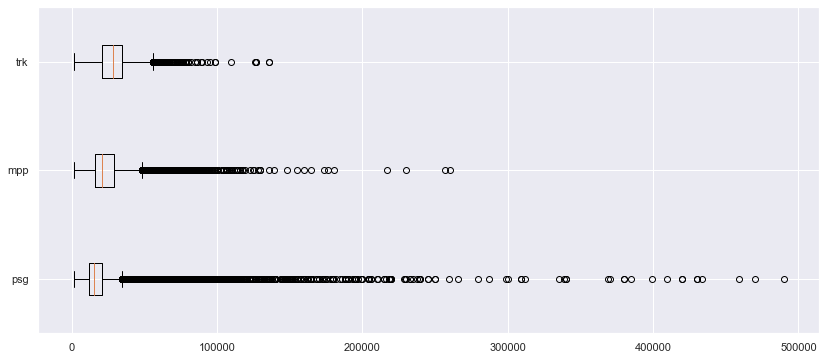

In [88]:
# Grafico de boxplot para observar la distribución de los precios por muestra
box_list = []
car_types = ['psg', 'mpp', 'trk']
for category in car_types:
    box_list += [samples[category]['y_val']]

plt.boxplot(box_list, labels=car_types, vert=False)
plt.show()

En conclusión:
* Se observa que las ditribuciones de las muestras de validación presentan un importante número de casos posibles de denominar como 'outliers', sinedo especialmente drámatico el caso de la muestra de 'psg'.
* Por lo tanto, sea modelo único o múltiple, se observan las limitaciones de la modelación, en los casos de vehículos de alta gama, cuyos precios superarían posiblemente los 60.000usd.
* A pesar de esta limitación, los rendimientos por separados muestran un mejor desempeño en datos no observados por el modelo al entrenarse, po lo que se prefería continuar con los modelos múltiples por tipode vehículo para desarrollar la solución.

## 5.4 Análisis de Distribución de Errores

In [89]:
# generación de lista con bases de Validación con atributos.
X_val_list=[X_val,samples["psg"]["X_val"],samples["mpp"]["X_val"],samples["trk"]["X_val"]]
# generación de lista con bases de Validación con vector objetivo.
y_val_list=[y_val,samples["psg"]["y_val"],samples["mpp"]["y_val"],samples["trk"]["y_val"]]
# generación de lista con modelos.
model_list=[lgb_best.best_model, psg_best.best_model,mpp_best.best_model,trk_best.best_model]

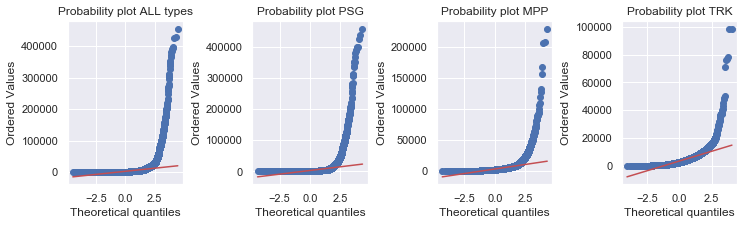

In [90]:
# QQ Plot
fn.qq_plot(model_list,X_val_list, y_val_list)

__Comentarios__:
De manera adicional a las métricas de RMSE y MAE, proponemos observar la conducta de los modelos con un QQ plot. Este gráfico comparara la distribución de los errores (residuos) con la distribución normal. Los gráficos muestran que los errores de los modelos tienen buen comportamiento entre los cuartiles -4 y 2. La situación cambia con los cuartiles 2 y 4. Nuestros modelos fallan en mayor medida para autos de valores altos.

## 5.5 Feature importaces

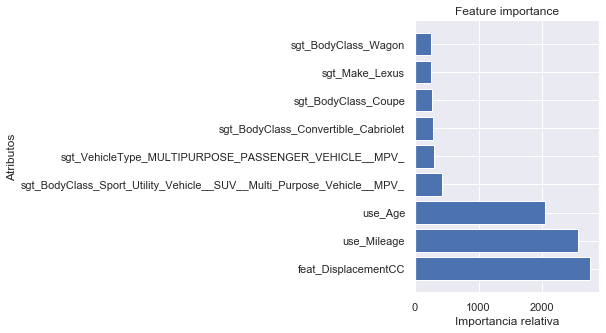

In [91]:
# feature importance modelo de pasageros psg
plt.rcParams['figure.figsize'] = (3.3, 5)
fn.grafico_importancia(model_list[0],X_val_list[0].columns)
plt.xlabel("Importancia relativa");
plt.ylabel('Atributos');

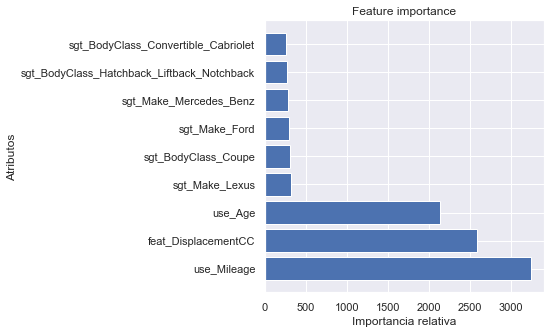

In [92]:
# feature importance modelo de multipropósiro (mpp)
plt.rcParams['figure.figsize'] = (5, 5)
fn.grafico_importancia(model_list[1],X_val_list[1].columns)
plt.xlabel("Importancia relativa");
plt.ylabel('Atributos');

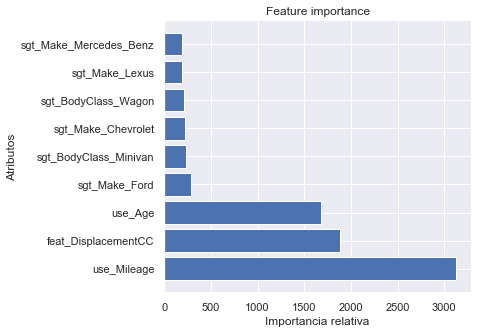

In [93]:
# feature importance modelo de truk (trk)
plt.rcParams['figure.figsize'] = (5.5, 5)
fn.grafico_importancia(model_list[2],X_val_list[2].columns)
plt.xlabel("Importancia relativa");
plt.ylabel('Atributos');

__Comentarios__:
Para los tres tipos de vehículos los atributos más importantes son Mileage (kilométrajes), Displacement (cilindrada) y use_age (antiguedad del vehículo).

## 5.6 Pipeline y Serialización

In [94]:
# Serializamos modelo único
# Generamos el objeto pipeline con nuestro mejor modelo y transformadores entrenados
pipeline = lgb_best.to_pipeline(df_prep.transformers, 
                                df_prep.df_ct.drop(columns=['Price', 'sample']))
# Serializamos el pipeline
pickle.dump(pipeline, open('best_models/pipeline_allcars.sav', 'wb'))

In [95]:
# Serializamos modelo múltiple
for category, model in car_models.items():
    
    # Generamos el objeto pipeline con nuestro mejor modelo y transformadores entrenados
    pipe = model.to_pipeline(samples[category]['transformers'], 
                             samples[category]['df_ct'].drop(columns=['Price', 'sample']))
    # Serializamos el pipeline
    pickle.dump(pipe, open(f'best_models/pipeline_{category}.sav', 'wb'))

# 6. Política de Recomendación

Habiendo definido un modelo que posbilite la estimación de un __precio de mercado__, para poder ofrecer una recomendación a través de la aplicación desarrollada debemos ofrecer una evaluación de posibles alternativas de compras. Actualmente podemos calcular el potencial margen de una oferta a través de la siguiente formula:
 
$$ m_{usd} = P_{estimado} - P_{ofertado}$$  
Siendo el $P_{estimado}$ el precio estimado por nuestro modelo y $P_{ofertado}$ el precio ofertado para poder adquirir el vehículo.  
Por otro lado, podemos establecer la misma métrica en términos porcentuales:

$$ m_{pct} = \frac{P_{estimado} - P_{ofertado}} {P_{estimado}}$$ 

Lo cual nos permite establecer una polítca de compra en base a términos porcentuales de margene requerido para considerar como una buena compra. Cómo el mercado automotriz es bien competitivo, especialmente en Estados Unidos, podemos definir que una compra con al menos un 8% de margen sea considerado como una compra recomendada, lo que podemos expresar con la siguiente formula:  

$$ m_{pct} - 0.08 > 0 => {Recomendado-comprar}$$

Pero cómo cualquier modelo de estimación de precios, nuestro modelo no es infalible. Cómo se mostró en la sección anterior, dependiendo del vehículo, este puede fallar en mayor o menor envergadura. Con la información utilizada para entrenar el modelo, podemos calcular el error en términos porcentuales para cada observación de esta muestra. De este cálculo podemos, generar la media de este error por modelo de vehículo, que es una variable que engloba muchos atributos relevantes del vehículo (ej: marca, tipo chasís, etc.) y por lo tanto de importancia para el precio, y por lo tanto generar un proxy estimativo del error que generaría el modelo ante una nueva observación. Dicho error histórico se puede representar de la siguiente forma:  

Error Histórico Promedio para Modelo j:   

$$ e_j = \frac {1}{n} \sum_{i=1}^{i\in j} \frac{P_{hist-estimado}-P_{hist-ofrecido}} {P_{hist-estimado}}$$


In [96]:
# Creamos la base para calcular los errores 
df_aux = df.loc[:, select_vars + ['sgt_Model']].dropna().reset_index(drop=True)
df_aux['Marca'] = df_aux['sgt_Make']
aux_dict = {value: key for key, value in car_dict.items()}
df_aux['ml_model'] = df_aux['sgt_VehicleType'].map(aux_dict)
df_aux = df_aux.drop(columns='sgt_VehicleType').rename(columns={'sgt_Model': 'Modelo'})
# Instanciamos la clase para preprocesamiento
prep_aux = PrepML(df_aux)
# Eliminación de Outliers
prep_aux.remove_outliers(['Price', 'use_Mileage', 'use_Age', 'feat_DisplacementCC', 
                         'feat_EngineCylinders'], 'sample', iqr_multiplier=1.5,
                          print_diff=False)
# Realizamos OneHot Encoder a las columnas categóricas seleccionadas
prep_aux.one_hot_encoder(['sgt_BodyClass', 'sgt_Make'],
                        drop_first=True)
# Estandarizamos variables continuas seleccionadas
prep_aux.standard_scaler(['use_Mileage', 'use_Age', 'feat_DisplacementCC', 
                         'feat_EngineCylinders'])
# Eliminamos la muestra de validación
df_aux = prep_aux.df[prep_aux.df['sample'] == 'train'].drop(columns='sample')
# Cambio de tipo de dato para 'ml_model'
ml_type = CategoricalDtype(categories=['psg', 'mpp', 'trk'], ordered=True)
df_aux = df_aux.astype({'ml_model': ml_type}).sort_values(by='ml_model')

In [97]:
# Realizamos las predicciones por categoría de vehículo
y_hat = []
for category, model in car_models.items(): 
    y_hat += list(model.best_model.predict(df_aux[df_aux['ml_model'] == category]\
                                               .loc[:, samples[category]['X_train'].columns]
                                          ))
# Redondeamos y pasamos a integer las predicciones
y_hat = [int(round(i, 0)) for i in y_hat] 

In [98]:
# Creamos las variables 'y_hat' y 'error'
df_aux['y_hat'] = y_hat
df_aux['error'] = (df_aux['y_hat'] - df_aux['Price'])/df_aux['y_hat']
df_aux['error'] = df_aux['error'].map(lambda x: round(x, 2))

In [99]:
# Error Promedio por Marca/Modelo
error_df = df_aux.loc[:, ['Marca', 'Modelo', 'Price', 'y_hat', 'error']]\
            .groupby(by=['Marca', 'Modelo'])\
            .agg({'Price': ['mean', 'count'], 'y_hat': 'mean', 'error': 'mean'})\
            .round(2)
error_df

Price           y_hat error
                         mean count      mean  mean
Marca Modelo                                       
Acura ILX4dr         15490.00     1  11850.00 -0.31
      ILX5_Speed     17226.38   478  12106.36 -0.42
      ILX6_Speed     17036.00    16  16916.31 -0.01
      ILXAcuraWatch  21728.17     6  24505.33  0.11
      ILXAutomatic   22399.49   147  22461.04 -0.01
...                       ...   ...       ...   ...
smart fortwoProxy    18269.00     2  15313.50 -0.18
      fortwoPure     13950.00    26  11926.88 -0.17
      fortwopassion   7743.95    65   7645.82 -0.02
      fortwoprime    14998.50     2  16140.50  0.07
      fortwopure      7348.66   123   7302.39 -0.01

[1745 rows x 4 columns]

Como se puede observar del cálculo de error por modelo, este puede diferir considerablemente y en distintas direcciones dependiendo del modelo del vehículo, subestimando o sobrestimando el precio de manera importante en ciertos casos. Es por ello que proponemos usar esta error histórico para ajustar el margen generado por el precio ofrecido y el precio estimado, de la siguiente forma:

Margen ajustado para oferta i de modelo j de vehículo:  
$$ ma_i = m_i - e_j $$

Pero si observamos más a fondo el error histórico, nos encontramos con que a pesar de la corrección, la estimación puede ser muy poco acertada, por lo que es necesario generar matices a esta correción:

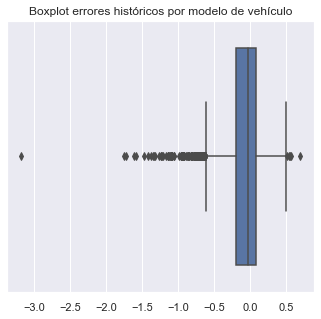

In [100]:
# Distribución del error histórico
ax = sns.boxplot(error_df['error'])
plt.title('Boxplot errores históricos por modelo de vehículo')
plt.show()

In [101]:
# Cuartiles y rango intercuartil de boxplot
q1 = error_df['error'].quantile(0.25).values[0]
q3 = error_df['error'].quantile(0.75).values[0]
iqr = q3 - q1
print(f'Primer Cuartil: {q1}\nTercer Cuartil: {q3}')
print(f'Bigote Inferior:{q1 - iqr*1.5}\nBigote Superior:{q3 + iqr*1.5}')


Primer Cuartil: -0.19
Tercer Cuartil: 0.09
Bigote Inferior:-0.6100000000000001
Bigote Superior:0.51


Por lo que para evitar malas recomendaciones, se evitará entregar una recomendación cuyos modelos de vehículos tengan precio de mercado con errores históricos superiores al $0.51$ o inferiores a $-0.61$, dado que aún con la correción, la estimación puede ser muy poco fíable. Bajo el mismo concepto, la recomendación se hará con reservas si, habiendose cumplido las condiciones de margen ajustado mayor a 5%, el error histórico promedio del modelo no se encuentra entre el primer y tercer quintil de la distribución de los errores históricos. Finalmente, a continuación se resume como la política de recomendación se establecería:

Para un oferta $i$ de modelo de vehículo $j$ con un margen mínimo desado de 8%:

`if` $(e_j <-0.61$ `or` $ e_j > 0.51)$ => `No hay Recomendación`   
`elif` $(m_i - e_j < 0.08 ) =>$ `No Recomendado para comprar`  
`elif` $(-0.19 <= e_j <= 0.09)$ `&` $(m_i - e_j >= 0.08) =>$ `Recomendado comprar con seguridad`  
`elif` $(e_j <-0.19$ `or` $ e_j > 0.09$) `&` ($m_i - e_j >= 0.08) =>$ `Recomendado comprar con reservas`  
